In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tensorflow.keras.utils import plot_model


from src.helper_functions import *
from src.build_models import *

from datetime import datetime
import datetime
import time

In [25]:


def create_data_gens1(train_dir = '../images/Images/train1', val_dir = '../images/Images/val1', holdout_dir =  '../images/Images/test1',  batch_size = 16):
    '''
    this is the augmentation configuration we will use for training
    PARAMS: train, val, holdout dirs are directories geared toward the storage of such data

    all images are resized to (150,150)

    RETURNS:
    each image generator in order train, val, holdout
   '''
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            train_dir, 
            shuffle=True, # this is the target directory
            target_size=(150, 150),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical')  # since we use CategoricalCrossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            val_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)

    h_out = ImageDataGenerator(rescale=1./255)
    # this is a similar generator, for validation data
    holdout_generator = h_out.flow_from_directory(
            holdout_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical')

    return train_generator, validation_generator, holdout_generator


In [27]:
train_generator, validation_generator, holdout_generator = create_data_gens1(train_dir = "../images/Images/train1",  val_dir = '../images/Images/val1', holdout_dir = '../images/Images/test1', batch_size = 16)

Found 3034 images belonging to 25 classes.
Found 650 images belonging to 25 classes.
Found 665 images belonging to 25 classes.


In [12]:
tensorboard, early_stopping = create_callbacks(file_path = "./logs/")

In [ ]:
basic_cnn_model = basic_cnn(n_categs=25)

mdl_check_trans = ModelCheckpoint(filepath='./logs/best_trans_model.hdf5', save_best_only=True)

basic_cnn_history = basic_cnn_model.fit(train_generator,
            steps_per_epoch=2000 // 16,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=500 // 16)

Epoch 1/100
125/125 [==============================] - 28s 224ms/step - loss: 3.2269 - accuracy: 0.0451 - top_k_categorical_accuracy: 0.2248 - val_loss: 3.2081 - val_accuracy: 0.0766 - val_top_k_categorical_accuracy: 0.2520
Epoch 2/100
125/125 [==============================] - 30s 237ms/step - loss: 3.2180 - accuracy: 0.0517 - top_k_categorical_accuracy: 0.2123 - val_loss: 3.2174 - val_accuracy: 0.0766 - val_top_k_categorical_accuracy: 0.2016
Epoch 3/100
125/125 [==============================] - 29s 235ms/step - loss: 3.2160 - accuracy: 0.0585 - top_k_categorical_accuracy: 0.2310 - val_loss: 3.2120 - val_accuracy: 0.0766 - val_top_k_categorical_accuracy: 0.2540
Epoch 4/100
125/125 [==============================] - 30s 243ms/step - loss: 3.2132 - accuracy: 0.0552 - top_k_categorical_accuracy: 0.2511 - val_loss: 3.2047 - val_accuracy: 0.0766 - val_top_k_categorical_accuracy: 0.2560
Epoch 5/100
125/125 [==============================] - 30s 242ms/step - loss: 3.2150 - accuracy: 0.0612 

ValueError: Format 'py' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

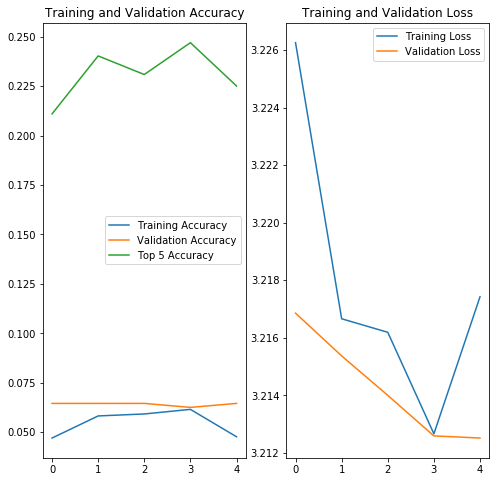

In [11]:
plot_acc_loss_per_epoch(basic_cnn_history, epochs = 5, file_name = 'basic_cnn_compare.png')

In [28]:
Xception_transfer_model = basic_transfer_model(input_size = (150,150,3), n_categories = 25, trans_model = Xception)
change_trainable_layers(Xception_transfer_model, 131)

Xception_transfer_model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy', 'top_k_categorical_accuracy'])

mdl_check_trans = ModelCheckpoint(filepath='./logs/best_trans_model.hdf5', save_best_only=True)
Xception_history = Xception_transfer_model.fit(train_generator,
            steps_per_epoch=3034 // 15,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=650 // 16,
            verbose = 1)

# Xception_transfer_model.save('Xception_mod.h5')

Epoch 1/100
202/202 [==============================] - 172s 854ms/step - loss: 2.3499 - accuracy: 0.3543 - top_k_categorical_accuracy: 0.6622 - val_loss: 1.1075 - val_accuracy: 0.6953 - val_top_k_categorical_accuracy: 0.9375
Epoch 2/100
202/202 [==============================] - 171s 848ms/step - loss: 1.8666 - accuracy: 0.4727 - top_k_categorical_accuracy: 0.7816 - val_loss: 1.0147 - val_accuracy: 0.7531 - val_top_k_categorical_accuracy: 0.9453
Epoch 3/100
202/202 [==============================] - 171s 848ms/step - loss: 1.6910 - accuracy: 0.5176 - top_k_categorical_accuracy: 0.8196 - val_loss: 1.1271 - val_accuracy: 0.7484 - val_top_k_categorical_accuracy: 0.9375
Epoch 4/100
202/202 [==============================] - 171s 848ms/step - loss: 1.6763 - accuracy: 0.5143 - top_k_categorical_accuracy: 0.8163 - val_loss: 1.1440 - val_accuracy: 0.7359 - val_top_k_categorical_accuracy: 0.9359
Epoch 5/100
202/202 [==============================] - 172s 854ms/step - loss: 1.5807 - accuracy: 0.

202/202 [==============================] - 172s 854ms/step - loss: 1.2511 - accuracy: 0.6237 - top_k_categorical_accuracy: 0.8933 - val_loss: 1.4503 - val_accuracy: 0.7609 - val_top_k_categorical_accuracy: 0.9438
Epoch 38/100
202/202 [==============================] - 173s 856ms/step - loss: 1.2373 - accuracy: 0.6383 - top_k_categorical_accuracy: 0.9048 - val_loss: 1.4228 - val_accuracy: 0.7563 - val_top_k_categorical_accuracy: 0.9453
Epoch 39/100
202/202 [==============================] - 173s 854ms/step - loss: 1.2615 - accuracy: 0.6271 - top_k_categorical_accuracy: 0.8961 - val_loss: 1.5083 - val_accuracy: 0.7469 - val_top_k_categorical_accuracy: 0.9391
Epoch 40/100
202/202 [==============================] - 173s 856ms/step - loss: 1.2840 - accuracy: 0.6219 - top_k_categorical_accuracy: 0.8923 - val_loss: 1.5141 - val_accuracy: 0.7453 - val_top_k_categorical_accuracy: 0.9359
Epoch 41/100
202/202 [==============================] - 172s 852ms/step - loss: 1.2090 - accuracy: 0.6491 - t

202/202 [==============================] - 172s 851ms/step - loss: 1.1671 - accuracy: 0.6525 - top_k_categorical_accuracy: 0.9121 - val_loss: 1.7133 - val_accuracy: 0.7484 - val_top_k_categorical_accuracy: 0.9438
Epoch 74/100
202/202 [==============================] - 172s 851ms/step - loss: 1.1584 - accuracy: 0.6503 - top_k_categorical_accuracy: 0.9180 - val_loss: 1.7084 - val_accuracy: 0.7312 - val_top_k_categorical_accuracy: 0.9344
Epoch 75/100
202/202 [==============================] - 172s 853ms/step - loss: 1.1740 - accuracy: 0.6547 - top_k_categorical_accuracy: 0.9087 - val_loss: 1.6818 - val_accuracy: 0.7453 - val_top_k_categorical_accuracy: 0.9375
Epoch 76/100
202/202 [==============================] - 176s 870ms/step - loss: 1.1693 - accuracy: 0.6534 - top_k_categorical_accuracy: 0.9172 - val_loss: 1.7264 - val_accuracy: 0.7359 - val_top_k_categorical_accuracy: 0.9359
Epoch 77/100
202/202 [==============================] - 190s 942ms/step - loss: 1.1545 - accuracy: 0.6606 - t

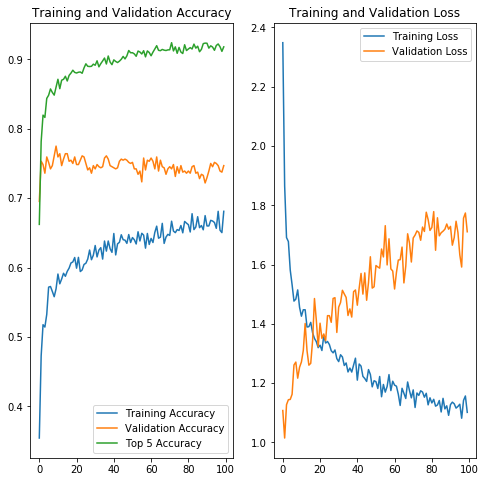

In [30]:
plot_acc_loss_per_epoch(Xception_history, epochs = 100, file_name='100_epoch_Xception.png')

In [14]:
InceptionV3_transfer_model = basic_transfer_model(input_size = (150,150,3), n_categories = 25, trans_model = InceptionV3)
change_trainable_layers(InceptionV3_transfer_model, 310)
InceptionV3_transfer_model.compile(optimizer='Nadam', loss=['categorical_crossentropy'], metrics=['accuracy', 'top_k_categorical_accuracy'])

mdl_check_trans = ModelCheckpoint(filepath='./logs/best_trans_model.hdf5', save_best_only=True)
InceptionV3_history = InceptionV3_transfer_model.fit(train_generator,
            steps_per_epoch=3034 // 15,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=650 // 16,
            verbose = 1,
            callbacks=[tensorboard])

Epoch 1/100
202/202 [==============================] - 84s 418ms/step - loss: 2.7498 - accuracy: 0.2226 - top_k_categorical_accuracy: 0.5050 - val_loss: 1.5453 - val_accuracy: 0.6891 - val_top_k_categorical_accuracy: 0.9266
Epoch 2/100
202/202 [==============================] - 80s 398ms/step - loss: 2.2566 - accuracy: 0.3655 - top_k_categorical_accuracy: 0.6924 - val_loss: 2.0131 - val_accuracy: 0.6781 - val_top_k_categorical_accuracy: 0.9219
Epoch 3/100
179/202 [=========================>....] - ETA: 7s - loss: 2.1772 - accuracy: 0.3744 - top_k_categorical_accuracy: 0.7147

KeyboardInterrupt: 

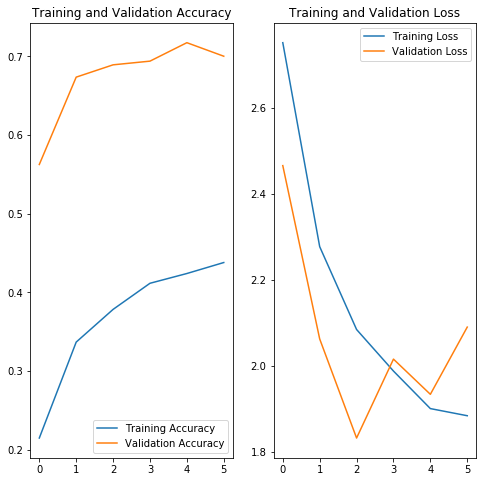

In [60]:
plot_acc_loss_per_epoch(history, epochs = 6, file_name = 'InceptionV3_compare.png')


In [82]:
!tensorboard --logdir=logs/ --port=8889

TensorBoard 1.14.0a20190301 at http://43a7ce3886b3:8889 (Press CTRL+C to quit)
W0915 23:16:29.180408 140039889069824 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0915 23:16:29.911424 140039889069824 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
^C


In [24]:
metrics = evaluate_model(history, holdout_generator)

AttributeError: 'History' object has no attribute 'evaluate'

In [35]:
metrics

[1.0591290351890383, 0.7323308]

In [46]:
!tensorboard --logdir=logs/ --port=8889

TensorBoard 1.14.0a20190301 at http://43a7ce3886b3:8889 (Press CTRL+C to quit)
W0915 21:53:27.774112 139769093265152 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0915 21:53:27.985728 139769093265152 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
^C


In [37]:
basic_cnn_model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
mdl_check_trans = ModelCheckpoint(filepath='./logs/best_trans_model.hdf5', save_best_only=True)
basic_cnn_model.fit(train_generator,
            steps_per_epoch=3034 // 15,
            epochs=5,
            validation_data=validation_generator,
            validation_steps=650 // 16,
            verbose = 1,
            callbacks=[tensorboard, early_stopping])

Epoch 1/5
202/202 [==============================] - 53s 264ms/step - loss: 3.2244 - accuracy: 0.0437 - val_loss: 3.2141 - val_accuracy: 0.0656
Epoch 2/5
202/202 [==============================] - 55s 274ms/step - loss: 3.2064 - accuracy: 0.0620 - val_loss: 3.2024 - val_accuracy: 0.0766
Epoch 3/5
202/202 [==============================] - 51s 254ms/step - loss: 3.2005 - accuracy: 0.0688 - val_loss: 3.1709 - val_accuracy: 0.0812
Epoch 4/5
202/202 [==============================] - 54s 267ms/step - loss: 3.1979 - accuracy: 0.0639 - val_loss: 3.1539 - val_accuracy: 0.0766
Epoch 5/5
202/202 [==============================] - 53s 262ms/step - loss: 3.1791 - accuracy: 0.0719 - val_loss: 3.1449 - val_accuracy: 0.0797


In [38]:
test_predictions = basic_cnn_model.predict(holdout_generator)

In [43]:
np.argmax(test_predictions,axis=1)

array([ 1,  2,  2,  2, 11, 11, 11, 11,  2,  2,  1, 11,  1,  1, 11,  2, 11,
        6, 11,  1,  2,  2,  2,  2,  2,  1,  1,  2,  1,  6,  2,  2,  2,  1,
       22,  2,  2, 11,  1, 11,  1,  2,  2,  1, 11, 11,  6, 11, 11,  2,  2,
       11,  2,  1,  2,  2,  2,  2,  2, 11,  2, 11, 11,  2,  2, 22,  2, 11,
        1,  2,  2,  2,  1,  2,  1,  2, 11,  2, 11,  1, 11,  8,  1, 11, 22,
        2,  2,  2, 11,  1,  1,  2,  1, 18,  2,  2,  1, 11,  2,  8, 11,  1,
        1,  2,  2,  2, 11,  2,  2,  2,  2,  2,  2, 11,  1, 11,  1,  1, 11,
        2,  2, 11, 11,  1, 11,  2, 11,  1,  8, 11, 11,  1, 11,  2,  2, 11,
        4,  2,  2,  2,  2,  2,  2,  2,  1, 22,  4,  2,  1,  2,  1,  1,  2,
        6, 11,  2, 11,  1,  2, 11, 11, 11, 11,  1,  2,  4,  2,  1,  1,  2,
        2, 13, 11,  2,  1, 11,  2,  2,  1,  2,  1, 11, 22,  1,  1,  1, 11,
        2, 11,  2,  6,  2, 22,  2, 18,  2,  2, 11,  2, 11,  1,  1,  2,  2,
       11,  1,  1,  8,  2, 11, 22,  4,  1,  2,  8,  2,  2,  2,  1,  8,  1,
        1,  2,  2,  6,  2

In [47]:
holdout_generator

In [ ]:
# get model predictions
predictions = le.classes_[np.argmax(test_predictions,axis=1)] # get labels and reverse back to get the text labels
# get target labels
target_labels = le.classes_[np.argmax(y_test,axis=1)]

# Store in dataframe
predict_df = pd.DataFrame({'Target_Labels': target_labels, 'Predictions': predictions})
predict_df.head(20)